<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/Kaggle_Breast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- id :환자 식별 번호
- diagnosis : 양성여부(M=악성, B=양성)
- radius : 반경
- texture : 질감
- perimeter : 둘레
- area : 면적
- smoothness : 매끄러움
- compactness : 조그만 정도
- concavity : 오목함
- concave points : 오목한 점의 수
- symmetry : 대칭
- dimentsion : 차원
- _mean : 2~11 평균값
- _se : 12~21 표준오차
- _worst : 22~31  각 세포 구분들에서 제일 큰 3개의 값을 평균낸 값

#1. EDA: 데이터 사전 탐색

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings(action="ignore")

In [28]:
df = pd.read_csv("data.csv")
print(df.shape) #(569, 33)

(569, 33)


In [29]:
print(df.info()) #null값x, diagnosis:object (M = malignant(악성), B = benign(양성))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [30]:
print(df.head()) #Unnamed:32는 전부 NaN이므로 삭제  #id: unique하므로 삭제

         id diagnosis  ...  fractal_dimension_worst  Unnamed: 32
0    842302         M  ...                  0.11890          NaN
1    842517         M  ...                  0.08902          NaN
2  84300903         M  ...                  0.08758          NaN
3  84348301         M  ...                  0.17300          NaN
4  84358402         M  ...                  0.07678          NaN

[5 rows x 33 columns]


In [31]:
print(df.isnull().sum()) #Unnamed: 32 569개 결측치 -> 삭제

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [32]:
df = df.drop(["Unnamed: 32", "id"], axis=1) #Unnamed: 32 ,  id 삭제
print(df.shape) #(569, 31)

(569, 31)


In [33]:
print(df.describe())

       radius_mean  texture_mean  ...  symmetry_worst  fractal_dimension_worst
count   569.000000    569.000000  ...      569.000000               569.000000
mean     14.127292     19.289649  ...        0.290076                 0.083946
std       3.524049      4.301036  ...        0.061867                 0.018061
min       6.981000      9.710000  ...        0.156500                 0.055040
25%      11.700000     16.170000  ...        0.250400                 0.071460
50%      13.370000     18.840000  ...        0.282200                 0.080040
75%      15.780000     21.800000  ...        0.317900                 0.092080
max      28.110000     39.280000  ...        0.663800                 0.207500

[8 rows x 30 columns]


In [34]:
print(df["diagnosis"].value_counts()) #B(양성):357, M(악성):212 -> target data
print('양성', round(df['diagnosis'].value_counts()[0]/len(df) * 100,2)) #양성 62.74
print('악성', round(df['diagnosis'].value_counts()[1]/len(df) * 100,2)) #악성 37.26

B    357
M    212
Name: diagnosis, dtype: int64
양성 62.74
악성 37.26


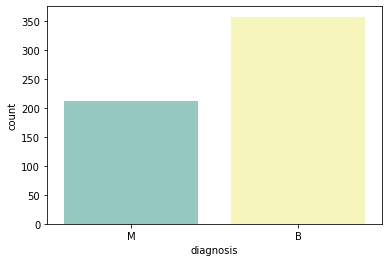

In [35]:
sns.countplot(x="diagnosis", data=df, palette='Set3')

- 총 569건의 데이터 중, 양성(B)이 357건(62.74%), 악성(M)이 212건(37.36%)로 양성종양이 악성종양의 1.5배 이상 높은 것으로 나타났다.

In [36]:
#target data 분리
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]
print(X.shape, y.shape)

(569, 30) (569,)


#2.결측치/이상치/Object --> 처리

In [41]:
#Object 처리(target data)
y = y.apply(lambda x : 0 if x =="B" else 1) #0이면 양성, 1이면 악성
print(pd.Series(y).value_counts())#array형이므로 reshape으로 바꿔줌
print(y.head())

0    357
1    212
Name: diagnosis, dtype: int64
0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64


In [42]:
#이상치 -> boxplot?
def CHECK_OUTLIER(df=None, column=None):
    Q1 = np.percentile(df[column].values, 25)
    Q3 = np.percentile(df[column].values, 75)
    IQR = Q3 - Q1
    IQR_weight = IQR * 1.5
    minimum = Q1 - IQR_weight
    maximum = Q3 + IQR_weight
    outlier_idx = df[column][  (df[column]<minimum) | (df[column]>maximum)  ].index
    return outlier_idx
    outlier_idx = CHECK_OUTLIER(df=df, column=col)
    print(col, oulier_idx)

numeric_columns = df.dtypes[df.dtypes != 'object'].index
for i, col in enumerate(numeric_columns) :
    outlier_idx = CHECK_OUTLIER(df=df, column=col)
    print(col , outlier_idx)
    #df.drop(outlier_idx, axis=0, inplace=True)

diagnosis Int64Index([], dtype='int64')
radius_mean Int64Index([82, 108, 122, 164, 180, 202, 212, 236, 339, 352, 369, 461, 503,
            521],
           dtype='int64')
texture_mean Int64Index([219, 232, 239, 259, 265, 455, 562], dtype='int64')
perimeter_mean Int64Index([82, 108, 122, 164, 180, 202, 212, 236, 339, 352, 461, 503, 521], dtype='int64')
area_mean Int64Index([ 23,  82, 108, 122, 164, 180, 202, 212, 236, 250, 265, 272, 339,
            352, 368, 369, 372, 373, 393, 449, 461, 503, 521, 563, 564],
           dtype='int64')
smoothness_mean Int64Index([3, 105, 122, 504, 520, 568], dtype='int64')
compactness_mean Int64Index([0, 3, 9, 12, 14, 78, 82, 108, 122, 181, 190, 258, 351, 352, 400,
            567],
           dtype='int64')
concavity_mean Int64Index([  0,  68,  78,  82, 108, 112, 122, 152, 180, 202, 212, 258, 351,
            352, 400, 461, 563, 567],
           dtype='int64')
concave points_mean Int64Index([78, 82, 108, 122, 180, 202, 212, 352, 393, 461], dtype='int64

- 총 데이터수(569개)에 비해 이상치가 많아서, 이상치를 drop시키고 분석할 경우 데이터가 빈약해질 우려가 있으므로 이상치 제거 없이 분석을 진행하기로 하였다.

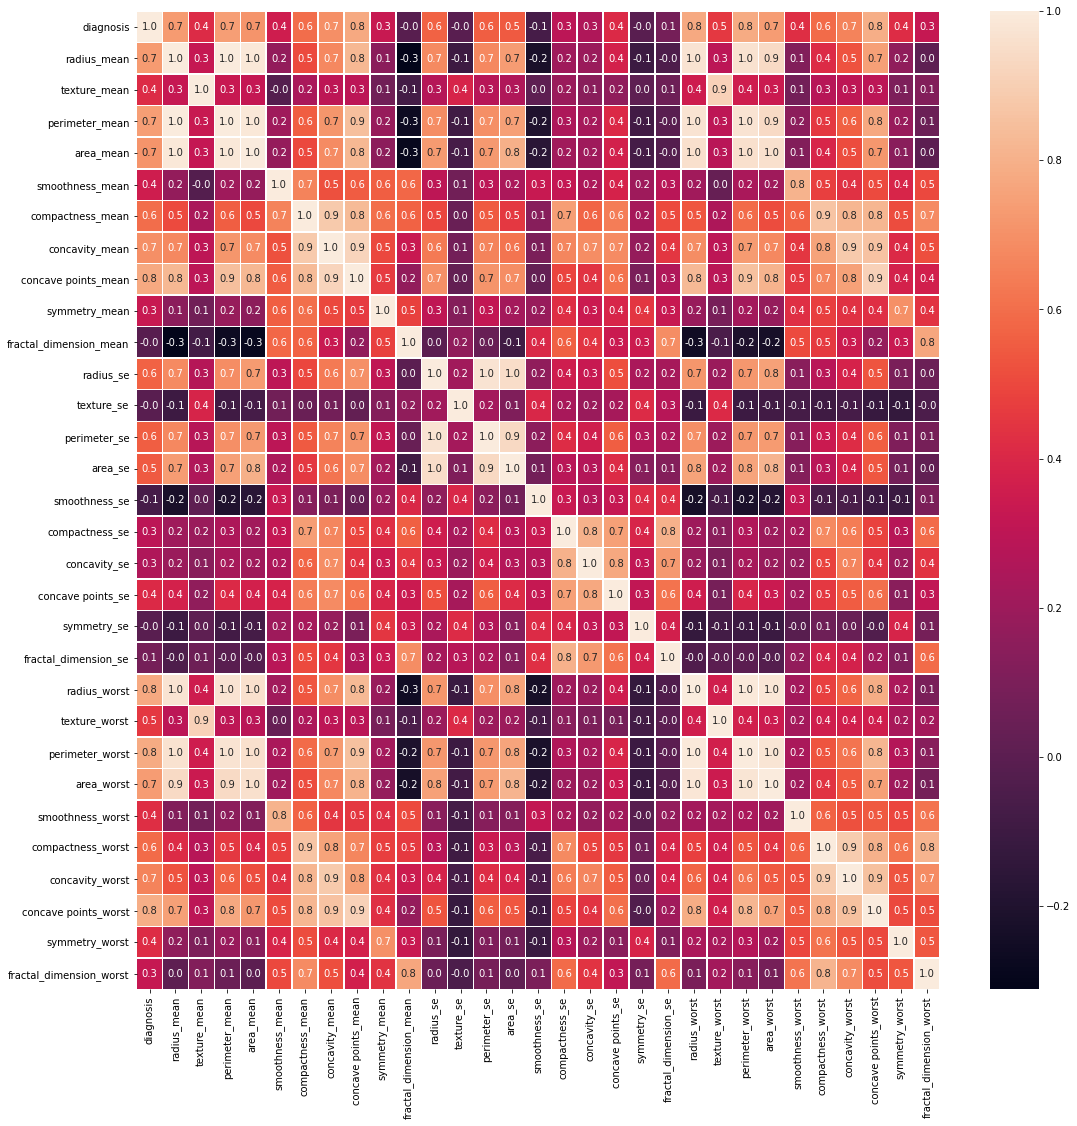

In [39]:
#상관분석
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

- 아래 일부 특성은 서로 밀접하게 관련되어 있음
    - radius_mean 과 perimeter_mean
    - radius_mean 과 texture_mean
    - perimeter_worst 와 radius_worst
    - perimeter_worst 와 area_worst
    - area_se 와 perimeter_se

#3. Feature Engineering 

In [49]:
#scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)

#4. 학습/평가

In [43]:
#모델 분석
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)
str = "최초 점수"

print("------{}-------".format(str))
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
auc = roc_auc_score(y_test, proba[:,1].reshape(-1,1))

print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f}  재현률{:.4f} auc{:.4f}) ".format(acc, f1, precision, recall, auc))
cf_matrix = confusion_matrix(y_test, pred)
print(cf_matrix)

------최초 점수-------
정확도0.9825  F1 0.9778=(정밀도0.9565  재현률1.0000 auc1.0000) 
[[68  2]
 [ 0 44]]


- RandomForest를 통하여 데이터를 분석한 결과, 정확도 0.9825, F1 0.9778의 높은 점수를 보였으나, 원본 데이터의 features수가 다소 많은 관계로 변수중요도 추출을 통해 추출한 주요 features 5개에 관하여 모델 분석을 행하고자 한다.

In [44]:
#변수중요도(Feature Importances)추출
features = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(features)

radius_worst               0.164031
concave points_worst       0.136849
perimeter_worst            0.120815
area_worst                 0.102618
concave points_mean        0.074558
perimeter_mean             0.044431
concavity_mean             0.044403
area_se                    0.042867
area_mean                  0.036622
radius_mean                0.030175
concavity_worst            0.029467
texture_mean               0.018230
texture_worst              0.018053
smoothness_worst           0.015749
perimeter_se               0.015476
compactness_worst          0.014092
symmetry_worst             0.013460
compactness_mean           0.009409
radius_se                  0.008912
fractal_dimension_se       0.008752
compactness_se             0.007469
smoothness_mean            0.006578
fractal_dimension_worst    0.006193
texture_se                 0.005893
fractal_dimension_mean     0.005044
symmetry_mean              0.004852
smoothness_se              0.004583
concave points_se          0

In [45]:
#상위 5개 features 추출
top_5_features = features.keys()[:5]
print(top_5_features)

Index(['radius_worst', 'concave points_worst', 'perimeter_worst', 'area_worst',
       'concave points_mean'],
      dtype='object')


- 상위 5개 feature를 추출한 결과, 'radius_worst', 'concave points_worst', 'perimeter_worst', 'area_worst', 'concavity_mean'로 나타났다.

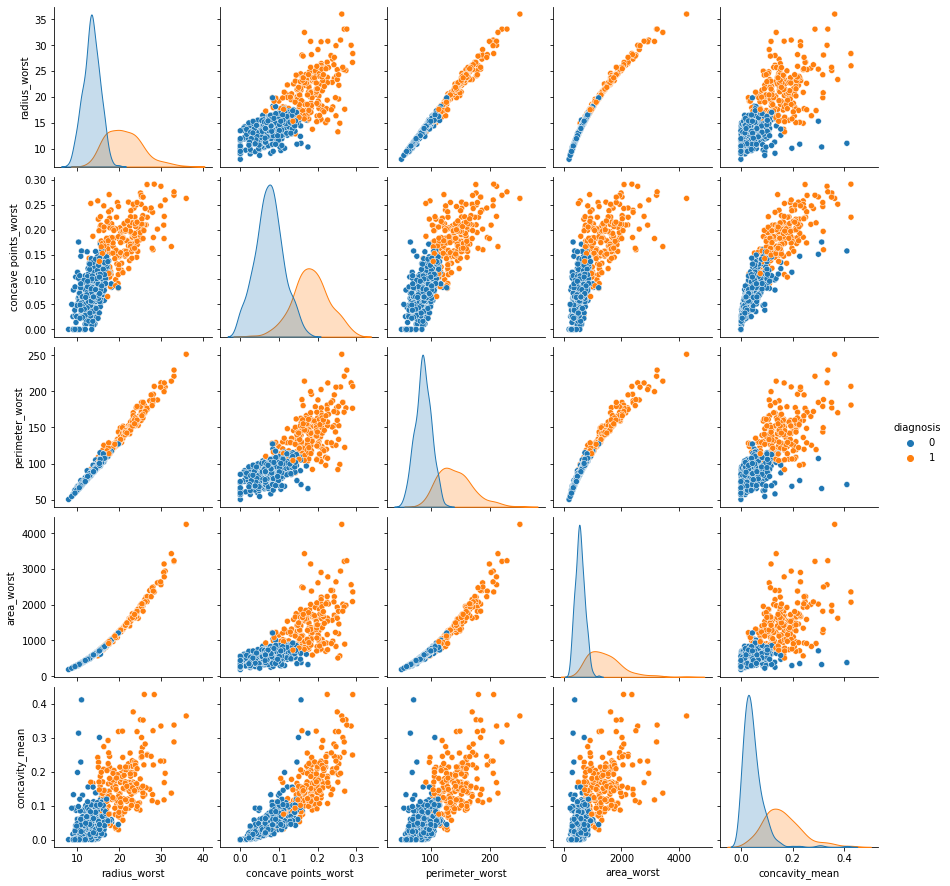

In [46]:
sns.pairplot(vars=['radius_worst', 'concave points_worst', 'perimeter_worst', 'area_worst', 'concavity_mean'], 
             hue='diagnosis', data=df)
plt.show()

In [ ]:
#상위 5개 feature로 모델 재분석
X_train, X_test, y_train, y_test = train_test_split(X[top_5_features], y, test_size=0.2, random_state=121, shuffle=True)
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)
str = "상위 5개 features 분석 결과"

print("------{}-------".format(str))
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
auc = roc_auc_score(y_test, proba[:,1].reshape(-1,1))

print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f}  재현률{:.4f} auc{:.4f}) ".format(acc, f1, precision, recall, auc))
cf_matrix = confusion_matrix(y_test, pred)
print(cf_matrix)


- 최초점수(정확도0.9825  F1 0.9778=(정밀도0.9565  재현률1.0000 auc1.0000))와 비교해본 결과, 상위 5개 features로 모델 분석 한 결과, 점수가 다소 감소하였다.

In [ ]:
#def CHART_PRECISION_RECALL_CURV(y_test, proba):
precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
print(len(precision), len(recall), len(th))
plt.plot(th, precision[:len(th)], label="precision")
plt.plot(th, recall[:len(th)], label="recall")
plt.xlabel("threadshold")
plt.ylabel("precision & recall value")
plt.legend()  # plt.legend(["precision","recall"])
plt.grid()
plt.show()

In [ ]:
#def CHART_ROC_CURV(y_test, proba, auc):
fpr, tpr, th = roc_curve(y_test, proba[:, 1])
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], label='th:0.5')
auc = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
plt.title(auc)
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.grid()
plt.show()

#5. 검증

In [ ]:
#Cross Validation
from sklearn.model_selection import cross_validate
my_score={"acc":"accuracy", "f1":"f1"} #scoring 여러개 주는 방법
score_list = cross_validate(model, X[top_5_features], y, scoring=my_score, cv=5, verbose=0)

In [ ]:
print("score_list----->", score_list)
score_df = pd.DataFrame(score_list)
print(score_df.head())
print("cross_validation 평균 정확도", score_df["test_acc"].mean())
print("cross_validation 평균 f1", score_df["test_f1"].mean())

- Cross Validation 교차검증 결과, 평균 정확도는 0.9473, 평균 F1은 0.9292로 확인되었다.
- 원본 데이터수가 작으므로, GridSearCV로 데이터를 증강, 튜닝하여 점수가 높아지는지 확인해 보고자 한다.

In [ ]:
my_hyper_param = { "n_estimators"      : [100, 300], # 랜덤 포레스트 안의 결정 트리 갯수 #default:100
                    "max_depth"        : [3,5,7,9], #최대 tree depth
                    "min_samples_leaf" : [1,3,5], #최소한으로 말단 노드 몇개 줄지 정함
                    "random_state"    :  [121,] #bootstrapping : 복원추출(나온번호 또 허용될 수 있음)
                } #randomforest의 parameter #랜덤포레스트가 가질 수 있는 파라미터를 여기에 지정해서 넣으면 됨


#GridSearchCV
from sklearn.model_selection import GridSearchCV
gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring="accuracy", refit=True, cv=5, verbose=0) #refit=true: 가장 잘나온 최적의 모델을 찾아냈으면 바로 예측에 반영시켜라  #cv : 몇번 돌릴건지 #f1이 scoring해주므로 밑에 score해줄 필요 x
#제일 좋은 모델 찾아서 학습 시키고 출력해라
#predict도 필요 없음. 내부적으로 파라미터을 준 갯수만큼 가장 좋았던 모델을 여기에 던져주므로

gcv_model.fit(X_train, y_train)
print("best_estimator_", gcv_model.best_estimator_) #제일 좋은 모델
print("best_params_",     gcv_model.best_params_) #제일 좋았던 파라미터
print("best_score_",     gcv_model.best_score_) #제일 잘나온 점수
y_pred = model.predict(X_test).astype(np.int32)

- GridSearchCV로 데이터를 증강한 결과, RandomForest의 결정트리 갯수가 100개, 최대 트리 깊이가 7, 최소 말단 노드가 1개일 때, 가장 좋은 점수를 출력하였으며, 가장 좋은 점수는 0.9626으로 확인되었다.